In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

# Optional gradient boosting libraries (guarded imports)
try:
    import lightgbm as lgb
except Exception as e:
    lgb = None
    print("LightGBM not available:", e)

try:
    import xgboost as xgb
except Exception as e:
    xgb = None
    print("XGBoost not available:", e)

try:
    import catboost as cbt
except Exception as e:
    cbt = None
    print("CatBoost not available:", e)

np.random.seed(42)
sns.set()


## Data Loading and Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

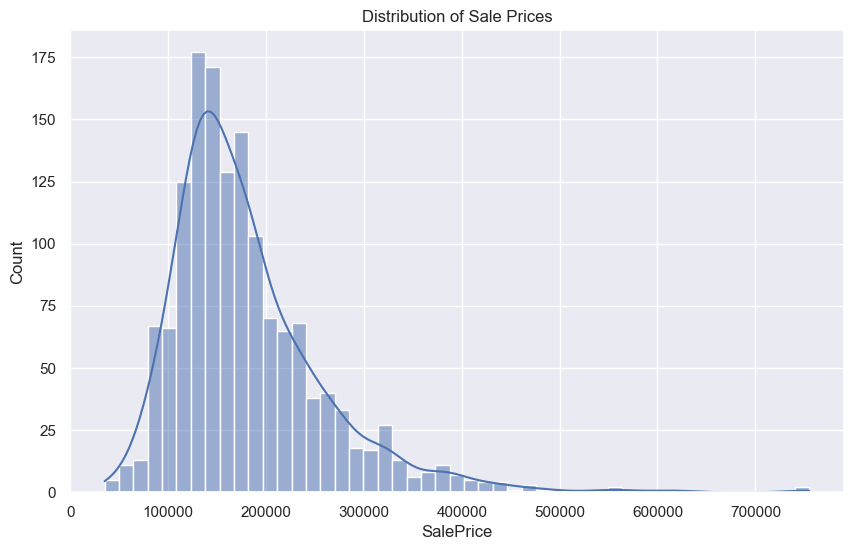

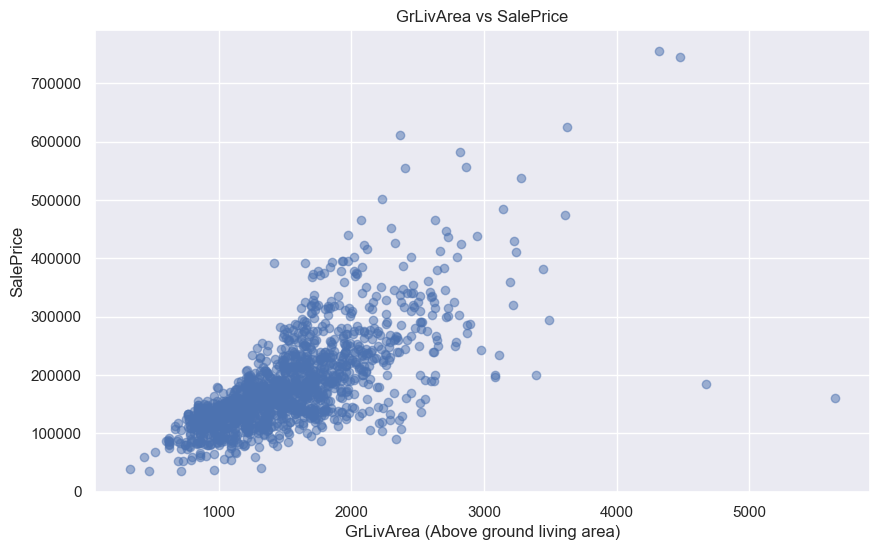

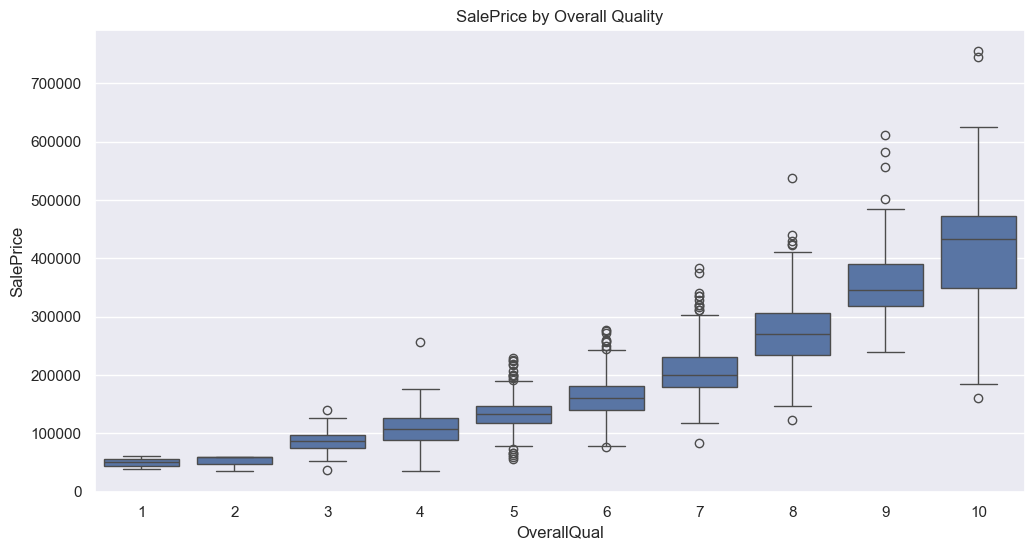

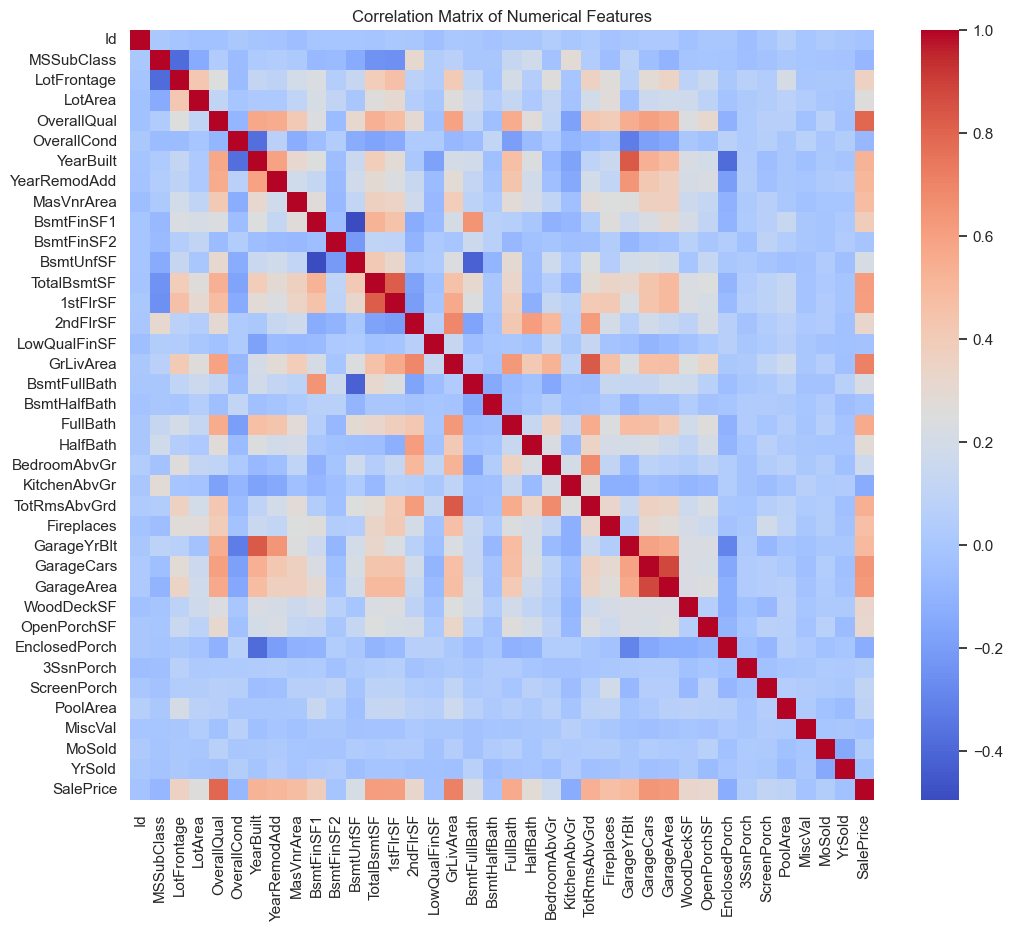

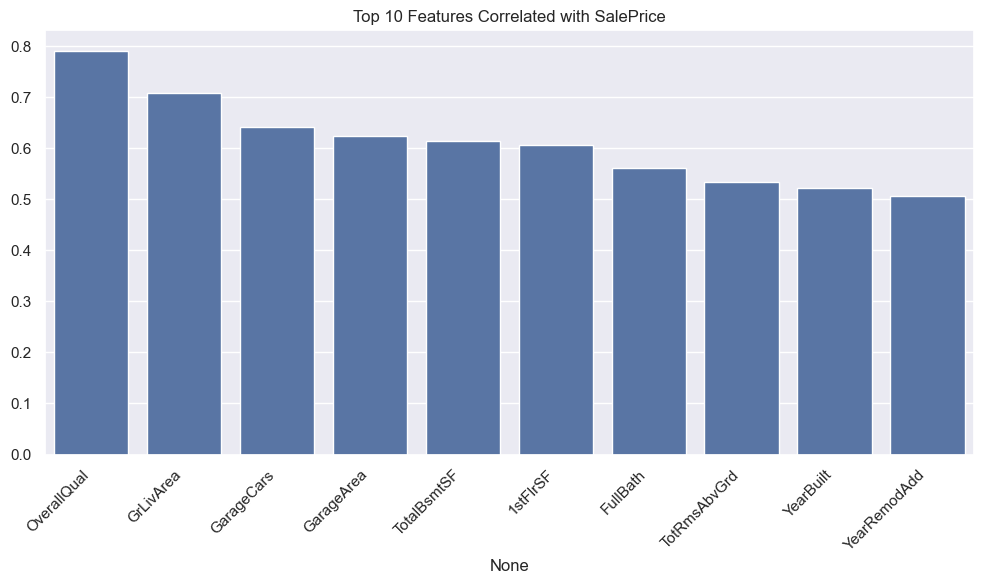

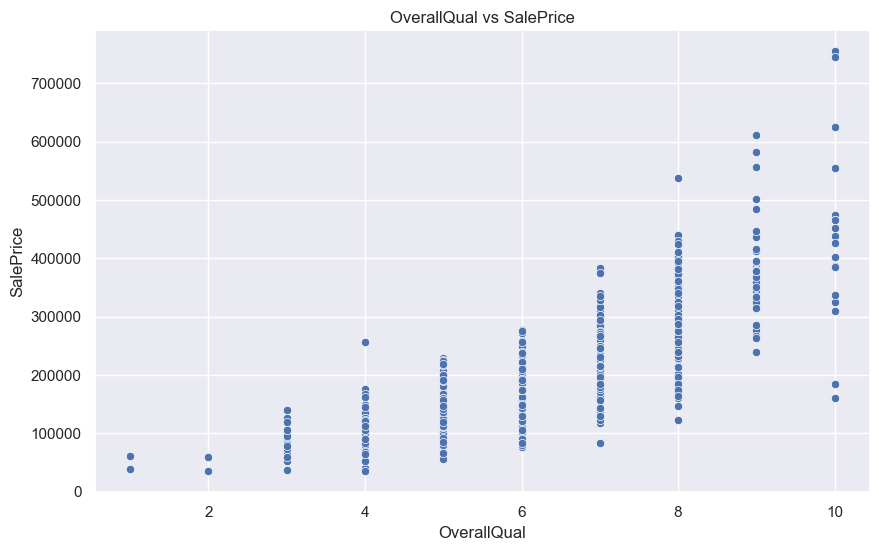

In [6]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Basic info
print(train.info())
print(train.describe())

# Distribution of target
plt.figure(figsize=(10, 6))
sns.histplot(train["SalePrice"], kde=True)
plt.title("Distribution of Sale Prices")
plt.show()

# GrLivArea vs SalePrice
plt.figure(figsize=(10, 6))
plt.scatter(train["GrLivArea"], train["SalePrice"], alpha=0.5)
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea (Above ground living area)")
plt.ylabel("SalePrice")
plt.show()

# Box plot SalePrice by OverallQual
plt.figure(figsize=(12, 6))
sns.boxplot(x="OverallQual", y="SalePrice", data=train)
plt.title("SalePrice by Overall Quality")
plt.show()

# Correlation heatmap for numeric columns
numeric_columns = train.select_dtypes(include=[np.number]).columns
corr_matrix = train[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Top correlated with SalePrice
top_corr = corr_matrix["SalePrice"].sort_values(ascending=False).head(11)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.index[1:], y=top_corr.values[1:])
plt.title("Top 10 Features Correlated with SalePrice")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top_feature = top_corr.index[1]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train[top_feature], y=train["SalePrice"])
plt.title(f"{top_feature} vs SalePrice")
plt.show()

## Data Descriptions

- **SalePrice** — The property's sale price in dollars *(target variable)*  
- **MSSubClass** — The building class  
- **MSZoning** — The general zoning classification  
- **LotFrontage** — Linear feet of street connected to property  
- **LotArea** — Lot size in square feet  
- **Street** — Type of road access  
- **Alley** — Type of alley access  
- **LotShape** — General shape of property  
- **LandContour** — Flatness of the property  
- **Utilities** — Type of utilities available  
- **LotConfig** — Lot configuration  
- **LandSlope** — Slope of property  
- **Neighborhood** — Physical locations within Ames city limits  
- **Condition1** — Proximity to main road or railroad  
- **Condition2** — Proximity to main road or railroad (if a second is present)  
- **BldgType** — Type of dwelling  
- **HouseStyle** — Style of dwelling  
- **OverallQual** — Overall material and finish quality  
- **OverallCond** — Overall condition rating  
- **YearBuilt** — Original construction date  
- **YearRemodAdd** — Remodel date  
- **RoofStyle** — Type of roof  
- **RoofMatl** — Roof material  
- **Exterior1st** — Exterior covering on house  
- **Exterior2nd** — Exterior covering on house (if more than one material)  
- **MasVnrType** — Masonry veneer type  
- **MasVnrArea** — Masonry veneer area in square feet  
- **ExterQual** — Exterior material quality  
- **ExterCond** — Present condition of the material on the exterior  
- **Foundation** — Type of foundation  
- **BsmtQual** — Height of the basement  
- **BsmtCond** — General condition of the basement  
- **BsmtExposure** — Walkout or garden level basement walls  
- **BsmtFinType1** — Quality of basement finished area  
- **BsmtFinSF1** — Type 1 finished square feet  
- **BsmtFinType2** — Quality of second finished area (if present)  
- **BsmtFinSF2** — Type 2 finished square feet  
- **BsmtUnfSF** — Unfinished square feet of basement area  
- **TotalBsmtSF** — Total square feet of basement area  
- **Heating** — Type of heating  
- **HeatingQC** — Heating quality and condition  
- **CentralAir** — Central air conditioning  
- **Electrical** — Electrical system  
- **1stFlrSF** — First floor square feet  
- **2ndFlrSF** — Second floor square feet  
- **LowQualFinSF** — Low quality finished square feet (all floors)  
- **GrLivArea** — Above grade (ground) living area square feet  
- **BsmtFullBath** — Basement full bathrooms  
- **BsmtHalfBath** — Basement half bathrooms  
- **FullBath** — Full bathrooms above grade  
- **HalfBath** — Half baths above grade  
- **Bedroom** — Number of bedrooms above basement level  
- **Kitchen** — Number of kitchens  
- **KitchenQual** — Kitchen quality  
- **TotRmsAbvGrd** — Total rooms above grade (does not include bathrooms)  
- **Functional** — Home functionality rating  
- **Fireplaces** — Number of fireplaces  
- **FireplaceQu** — Fireplace quality  
- **GarageType** — Garage location  
- **GarageYrBlt** — Year garage was built  
- **GarageFinish** — Interior finish of the garage  
- **GarageCars** — Size of garage in car capacity  
- **GarageArea** — Size of garage in square feet  
- **GarageQual** — Garage quality  
- **GarageCond** — Garage condition  
- **PavedDrive** — Paved driveway  
- **WoodDeckSF** — Wood deck area in square feet  
- **OpenPorchSF** — Open porch area in square feet  
- **EnclosedPorch** — Enclosed porch area in square feet  
- **3SsnPorch** — Three season porch area in square feet  
- **ScreenPorch** — Screen porch area in square feet  
- **PoolArea** — Pool area in square feet  
- **PoolQC** — Pool quality  
- **Fence** — Fence quality  
- **MiscFeature** — Miscellaneous feature not covered in other categories  
- **MiscVal** — Value of miscellaneous feature  
- **MoSold** — Month Sold  
- **YrSold** — Year Sold  
- **SaleType** — Type of sale  
- **SaleCondition** — Condition of sale  

## Data Preprocessing

In [7]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Handle missing values: median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype != "object":
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "None")
    # Encode categorical variables using LabelEncoder
    # NOTE: For production, OneHotEncoder is typically better.
    for col in df.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# Create preprocessed matrices
X = preprocess_data(train.drop("SalePrice", axis=1))
y = np.log1p(train["SalePrice"])  # log-transform to handle skew
test_processed = preprocess_data(test)

# Standardize features for linear-family models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_processed_scaled = scaler.transform(test_processed)

print("Processed shapes:", X.shape, test_processed.shape)

Processed shapes: (1460, 80) (1459, 80)


## Model Training and Evaluation

In [8]:
def train_and_evaluate(model, X, y, test_data, model_name):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)

    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_mae = mean_absolute_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)

    print(f"{model_name} Results:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train R2 Score: {train_r2:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Validation R2 Score: {val_r2:.4f}\n")

    return model, (y_train, train_pred, y_val, val_pred)

# Linear models
linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
}

linear_results = {}
for name, model in linear_models.items():
    linear_results[name] = train_and_evaluate(model, X_scaled, y, test_processed_scaled, name)

# Advanced models
rf_model = RandomForestRegressor(random_state=42)
rf_trained, rf_results = train_and_evaluate(rf_model, X, y, test_processed, "Random Forest")

if lgb is not None:
    lgb_model = lgb.LGBMRegressor(random_state=42)
    lgb_trained, lgb_results = train_and_evaluate(lgb_model, X, y, test_processed, "LightGBM")
else:
    lgb_trained, lgb_results = None, None

if xgb is not None:
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_trained, xgb_results = train_and_evaluate(xgb_model, X, y, test_processed, "XGBoost")
else:
    xgb_trained, xgb_results = None, None

if cbt is not None:
    cbt_model = cbt.CatBoostRegressor(random_state=42, verbose=False)
    cbt_trained, cbt_results = train_and_evaluate(cbt_model, X, y, test_processed, "CatBoost")
else:
    cbt_trained, cbt_results = None, None


Linear Regression Results:
Train RMSE: 0.1306
Train MAE: 0.0894
Train R2 Score: 0.8881
Validation RMSE: 0.1553
Validation MAE: 0.1061
Validation R2 Score: 0.8708

Ridge Results:
Train RMSE: 0.1306
Train MAE: 0.0894
Train R2 Score: 0.8881
Validation RMSE: 0.1553
Validation MAE: 0.1061
Validation R2 Score: 0.8708

Lasso Results:
Train RMSE: 0.3904
Train MAE: 0.3034
Train R2 Score: 0.0000
Validation RMSE: 0.4332
Validation MAE: 0.3371
Validation R2 Score: -0.0058

ElasticNet Results:
Train RMSE: 0.3904
Train MAE: 0.3034
Train R2 Score: 0.0000
Validation RMSE: 0.4332
Validation MAE: 0.3371
Validation R2 Score: -0.0058

Random Forest Results:
Train RMSE: 0.0535
Train MAE: 0.0361
Train R2 Score: 0.9812
Validation RMSE: 0.1458
Validation MAE: 0.0986
Validation R2 Score: 0.8861

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

## Model Performance Visualization

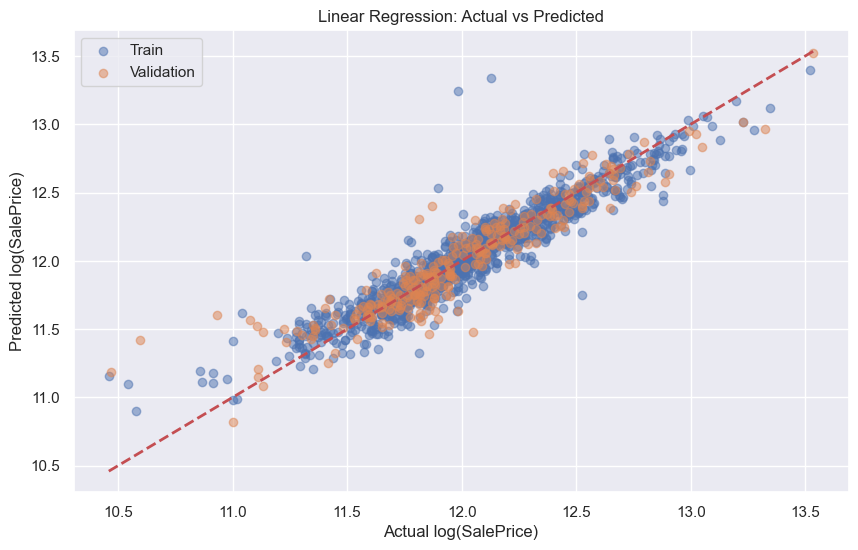

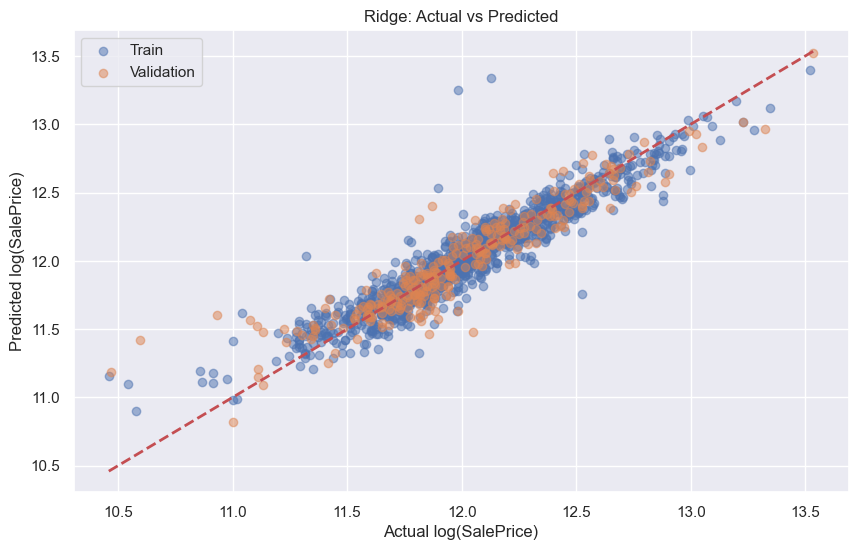

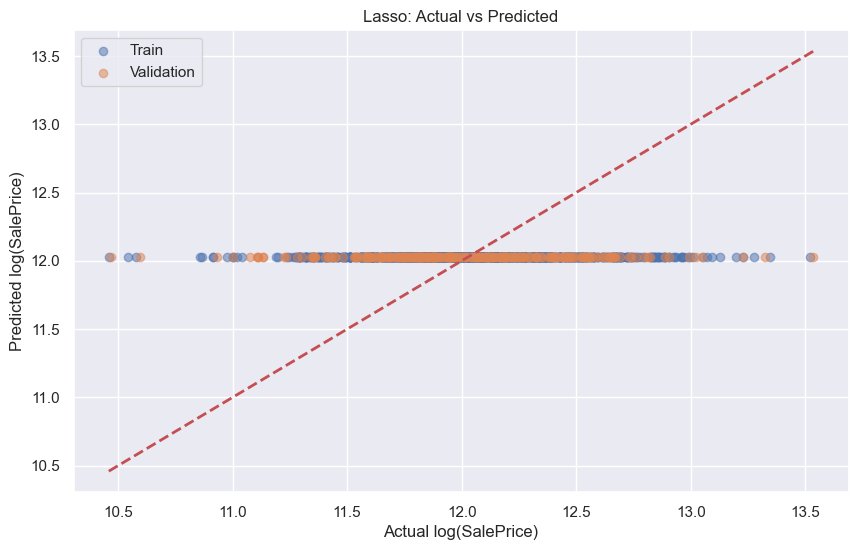

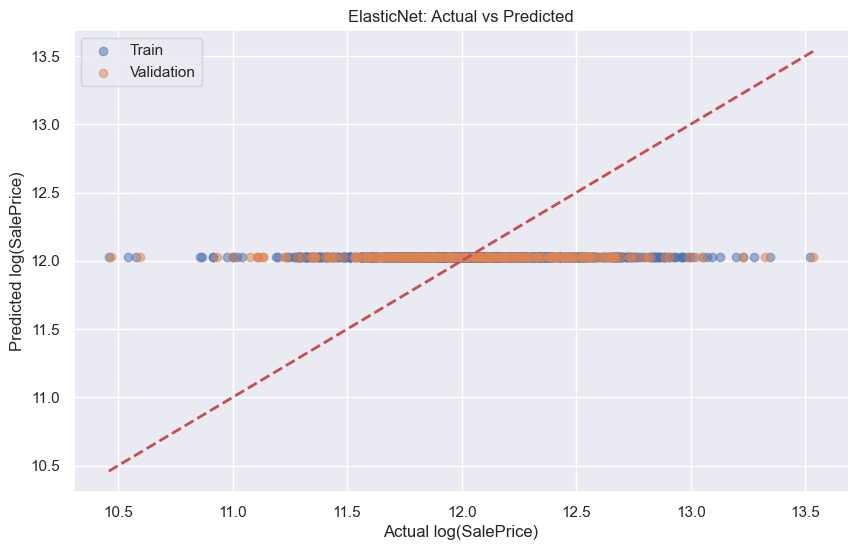

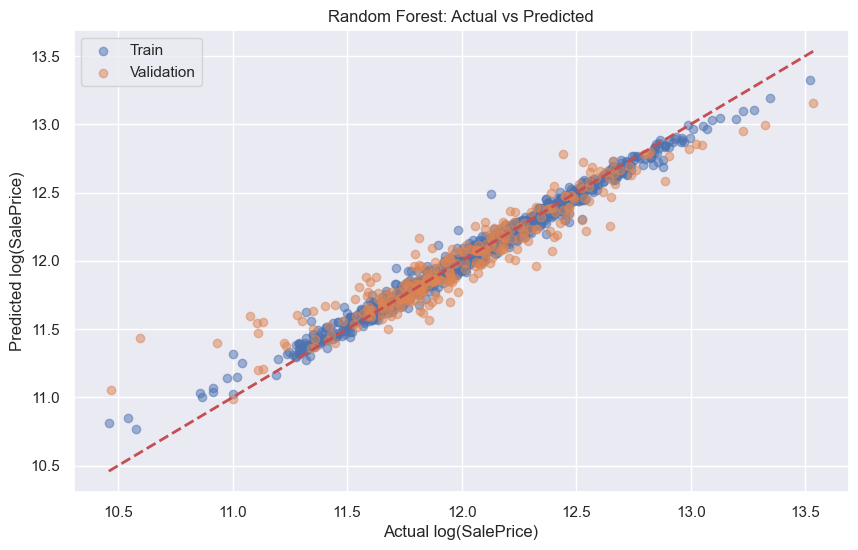

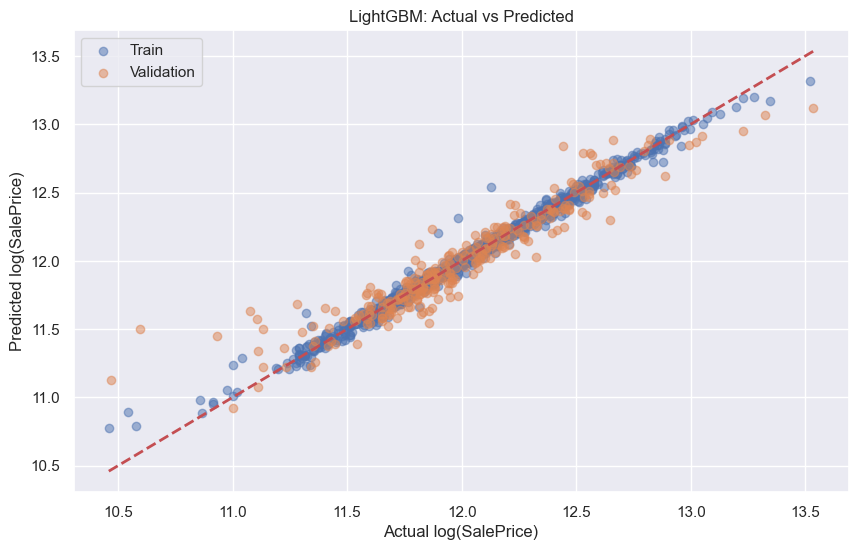

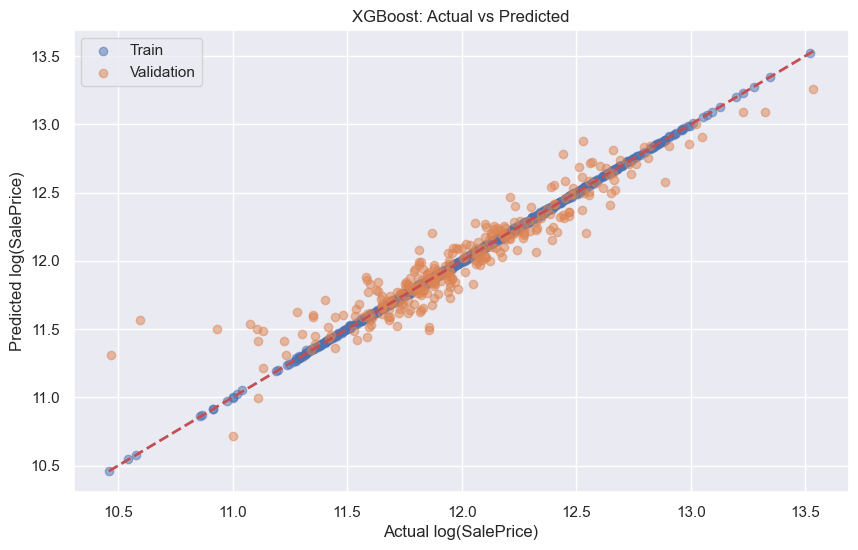

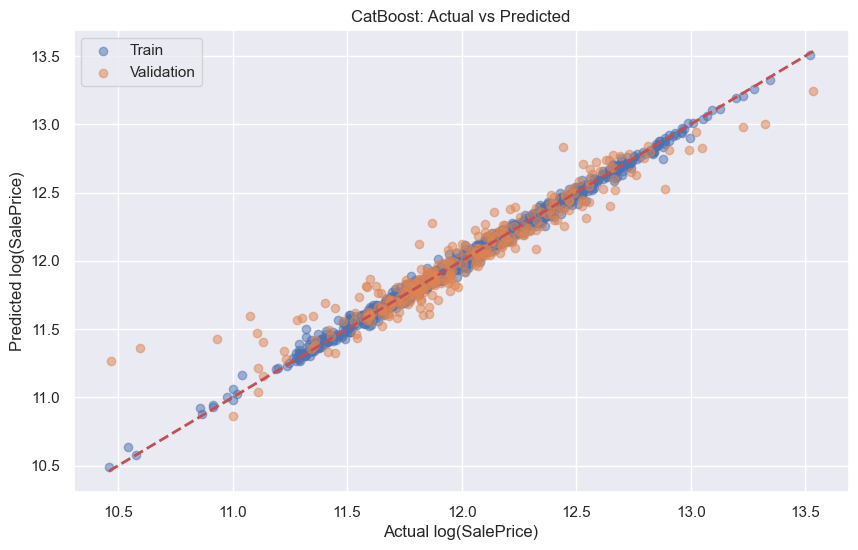

In [9]:
def plot_actual_vs_predicted(results, model_name):
    y_train, train_pred, y_val, val_pred = results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, train_pred, alpha=0.5, label="Train")
    plt.scatter(y_val, val_pred, alpha=0.5, label="Validation")
    y_all = np.concatenate([y_train, y_val])
    plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], "r--", lw=2)
    plt.xlabel("Actual log(SalePrice)")
    plt.ylabel("Predicted log(SalePrice)")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.legend()
    plt.show()

for name, (model, results) in linear_results.items():
    plot_actual_vs_predicted(results, name)

plot_actual_vs_predicted(rf_results, "Random Forest")
if lgb_results is not None:
    plot_actual_vs_predicted(lgb_results, "LightGBM")
if xgb_results is not None:
    plot_actual_vs_predicted(xgb_results, "XGBoost")
if cbt_results is not None:
    plot_actual_vs_predicted(cbt_results, "CatBoost")

## Feature Importance

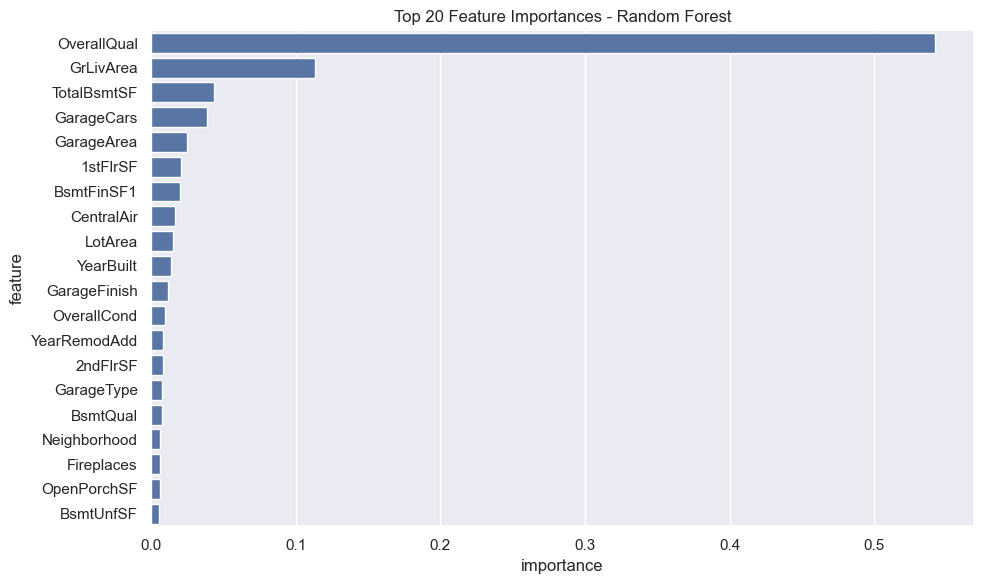

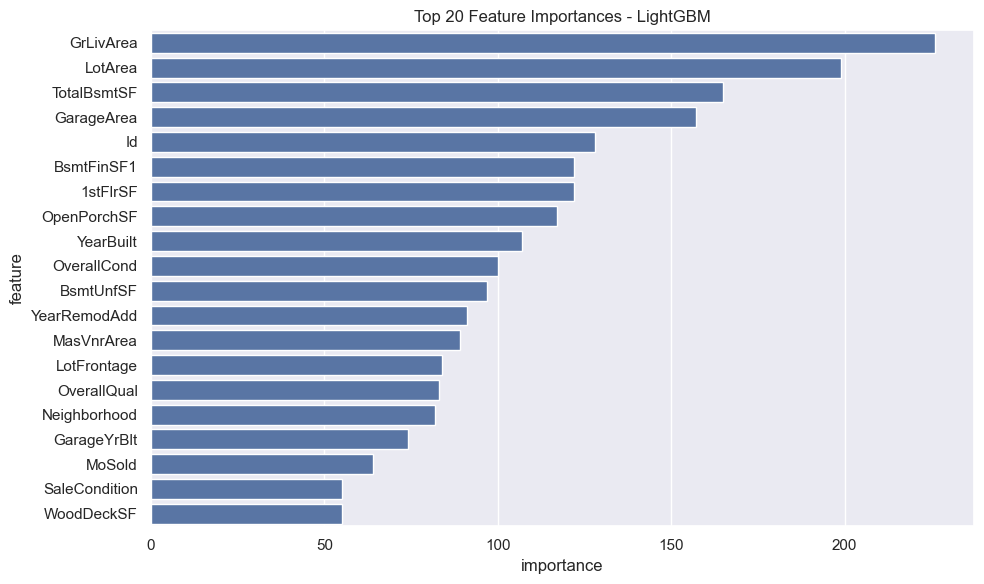

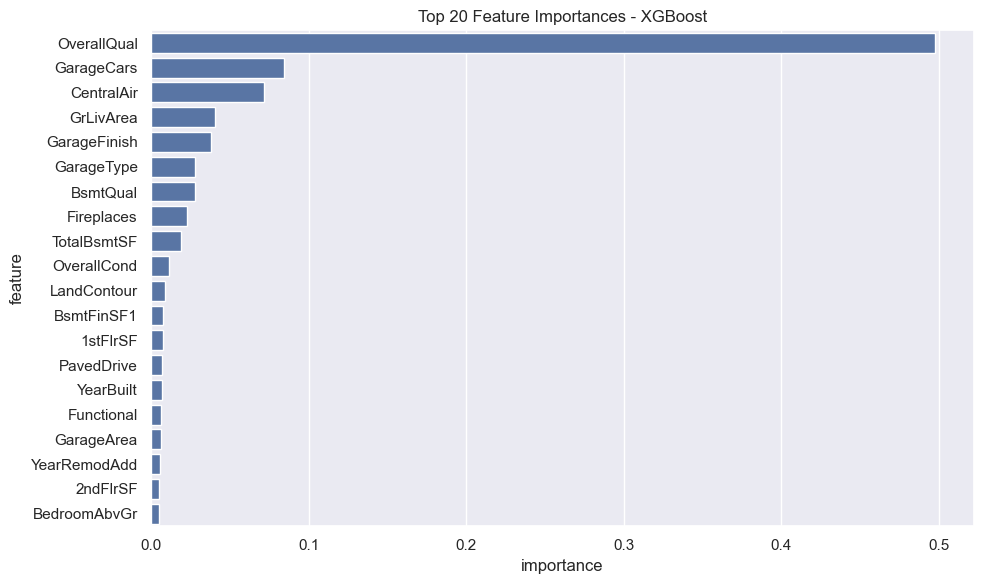

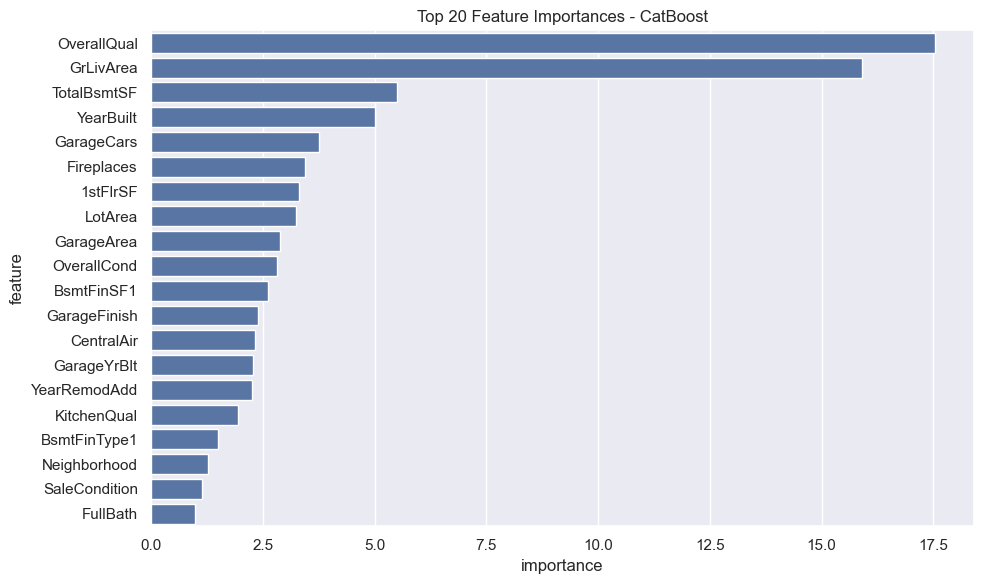

In [10]:
def plot_feature_importance(model, X_df, model_name):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "feature_importance"):
        importances = model.feature_importance()
    else:
        print(f"Feature importance not available for {model_name}")
        return

    feature_imp = pd.DataFrame({"feature": X_df.columns, "importance": importances}).sort_values(
        "importance", ascending=False
    ).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_imp)
    plt.title(f"Top 20 Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_trained, X, "Random Forest")
if lgb_trained is not None:
    plot_feature_importance(lgb_trained, X, "LightGBM")
if xgb_trained is not None:
    plot_feature_importance(xgb_trained, X, "XGBoost")
if cbt_trained is not None:
    plot_feature_importance(cbt_trained, X, "CatBoost")

## Hyperparameter Tuning

In [11]:
def tune_hyperparameters(model, param_grid, X, y, model_name):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        verbose=1,
        n_jobs=-1,
    )
    grid_search.fit(X, y)
    print(f"Best parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.4f}\n")
    return grid_search.best_estimator_

# Random Forest tuning
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
}
rf_tuned = tune_hyperparameters(RandomForestRegressor(random_state=42), rf_param_grid, X, y, "Random Forest")

# LightGBM tuning
if lgb is not None:
    lgb_param_grid = {
        "num_leaves": [31, 127],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
        "verbosity": [-1],
    }
    lgb_tuned = tune_hyperparameters(lgb.LGBMRegressor(random_state=42), lgb_param_grid, X, y, "LightGBM")
else:
    lgb_tuned = None

# XGBoost tuning
if xgb is not None:
    xgb_param_grid = {
        "max_depth": [3, 6],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
    }
    xgb_tuned = tune_hyperparameters(xgb.XGBRegressor(random_state=42), xgb_param_grid, X, y, "XGBoost")
else:
    xgb_tuned = None

# CatBoost tuning
if cbt is not None:
    cbt_param_grid = {
        "depth": [6, 8],
        "learning_rate": [0.01, 0.1],
        "iterations": [100, 200],
    }
    cbt_tuned = tune_hyperparameters(cbt.CatBoostRegressor(random_state=42, verbose=False), cbt_param_grid, X, y, "CatBoost")
else:
    cbt_tuned = None


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: 0.1423

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for LightGBM:
{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 127, 'verbosity': -1}
Best RMSE: 0.1338

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best RMSE: 0.1271

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for CatBoost:
{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best RMSE: 0.1248



## Final Model Evaluation

Final Model Evaluation:
Random Forest (Tuned) Results:
Train RMSE: 0.0597
Train MAE: 0.0395
Train R2 Score: 0.9766
Validation RMSE: 0.1463
Validation MAE: 0.0984
Validation R2 Score: 0.8853

LightGBM (Tuned) Results:
Train RMSE: 0.0381
Train MAE: 0.0192
Train R2 Score: 0.9905
Validation RMSE: 0.1410
Validation MAE: 0.0921
Validation R2 Score: 0.8935

XGBoost (Tuned) Results:
Train RMSE: 0.0622
Train MAE: 0.0456
Train R2 Score: 0.9746
Validation RMSE: 0.1372
Validation MAE: 0.0919
Validation R2 Score: 0.8991

CatBoost (Tuned) Results:
Train RMSE: 0.0606
Train MAE: 0.0450
Train R2 Score: 0.9759
Validation RMSE: 0.1334
Validation MAE: 0.0871
Validation R2 Score: 0.9047



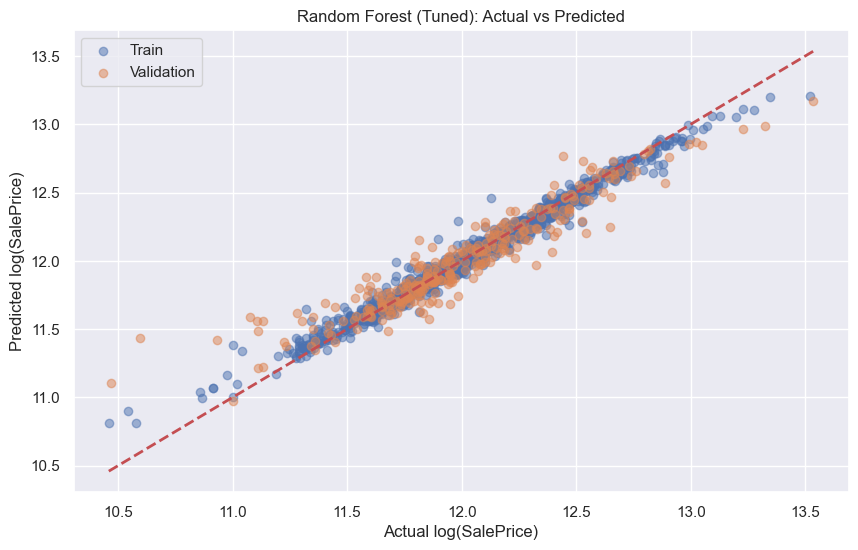

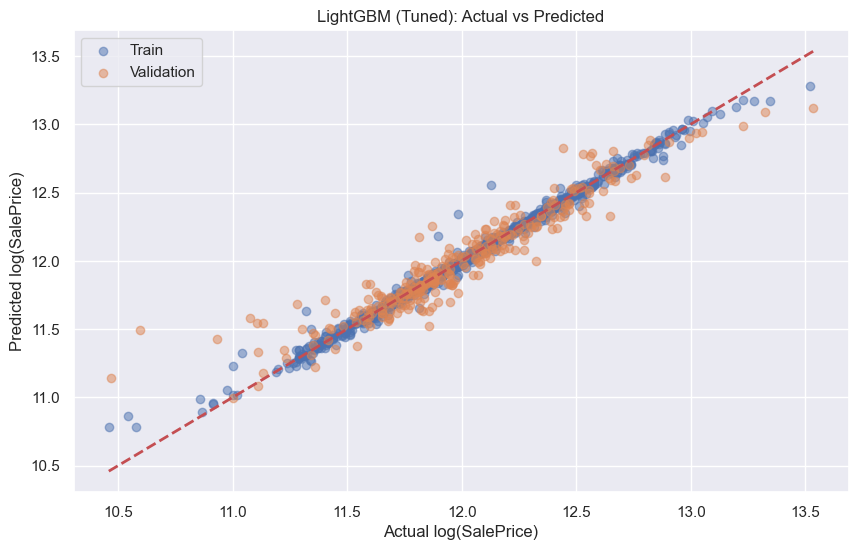

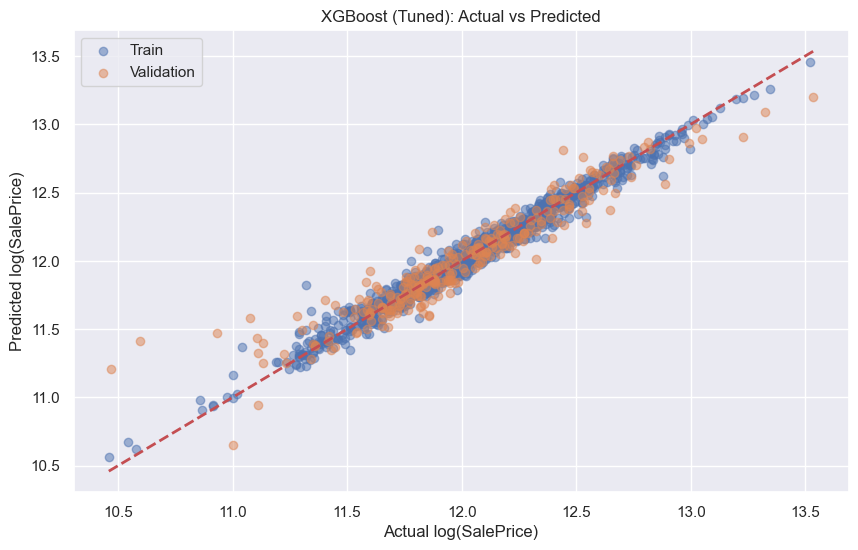

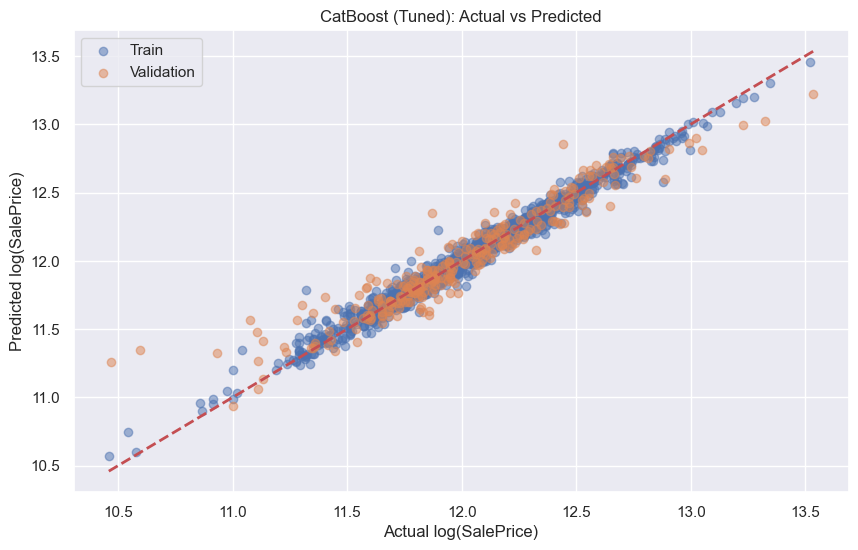

In [14]:
print("Final Model Evaluation:")
rf_final, rf_final_results = train_and_evaluate(rf_tuned, X, y, test_processed, "Random Forest (Tuned)")

if lgb_tuned is not None:
    lgb_final, lgb_final_results = train_and_evaluate(lgb_tuned, X, y, test_processed, "LightGBM (Tuned)")
else:
    lgb_final, lgb_final_results = None, None

if xgb_tuned is not None:
    xgb_final, xgb_final_results = train_and_evaluate(xgb_tuned, X, y, test_processed, "XGBoost (Tuned)")
else:
    xgb_final, xgb_final_results = None, None

if cbt_tuned is not None:
    cbt_final, cbt_final_results = train_and_evaluate(cbt_tuned, X, y, test_processed, "CatBoost (Tuned)")
else:
    cbt_final, cbt_final_results = None, None

# Plots for tuned models
plot_actual_vs_predicted(rf_final_results, "Random Forest (Tuned)")
if lgb_final_results is not None:
    plot_actual_vs_predicted(lgb_final_results, "LightGBM (Tuned)")
if xgb_final_results is not None:
    plot_actual_vs_predicted(xgb_final_results, "XGBoost (Tuned)")
if cbt_final_results is not None:
    plot_actual_vs_predicted(cbt_final_results, "CatBoost (Tuned)")

## Actual vs Predicted Price Comparison

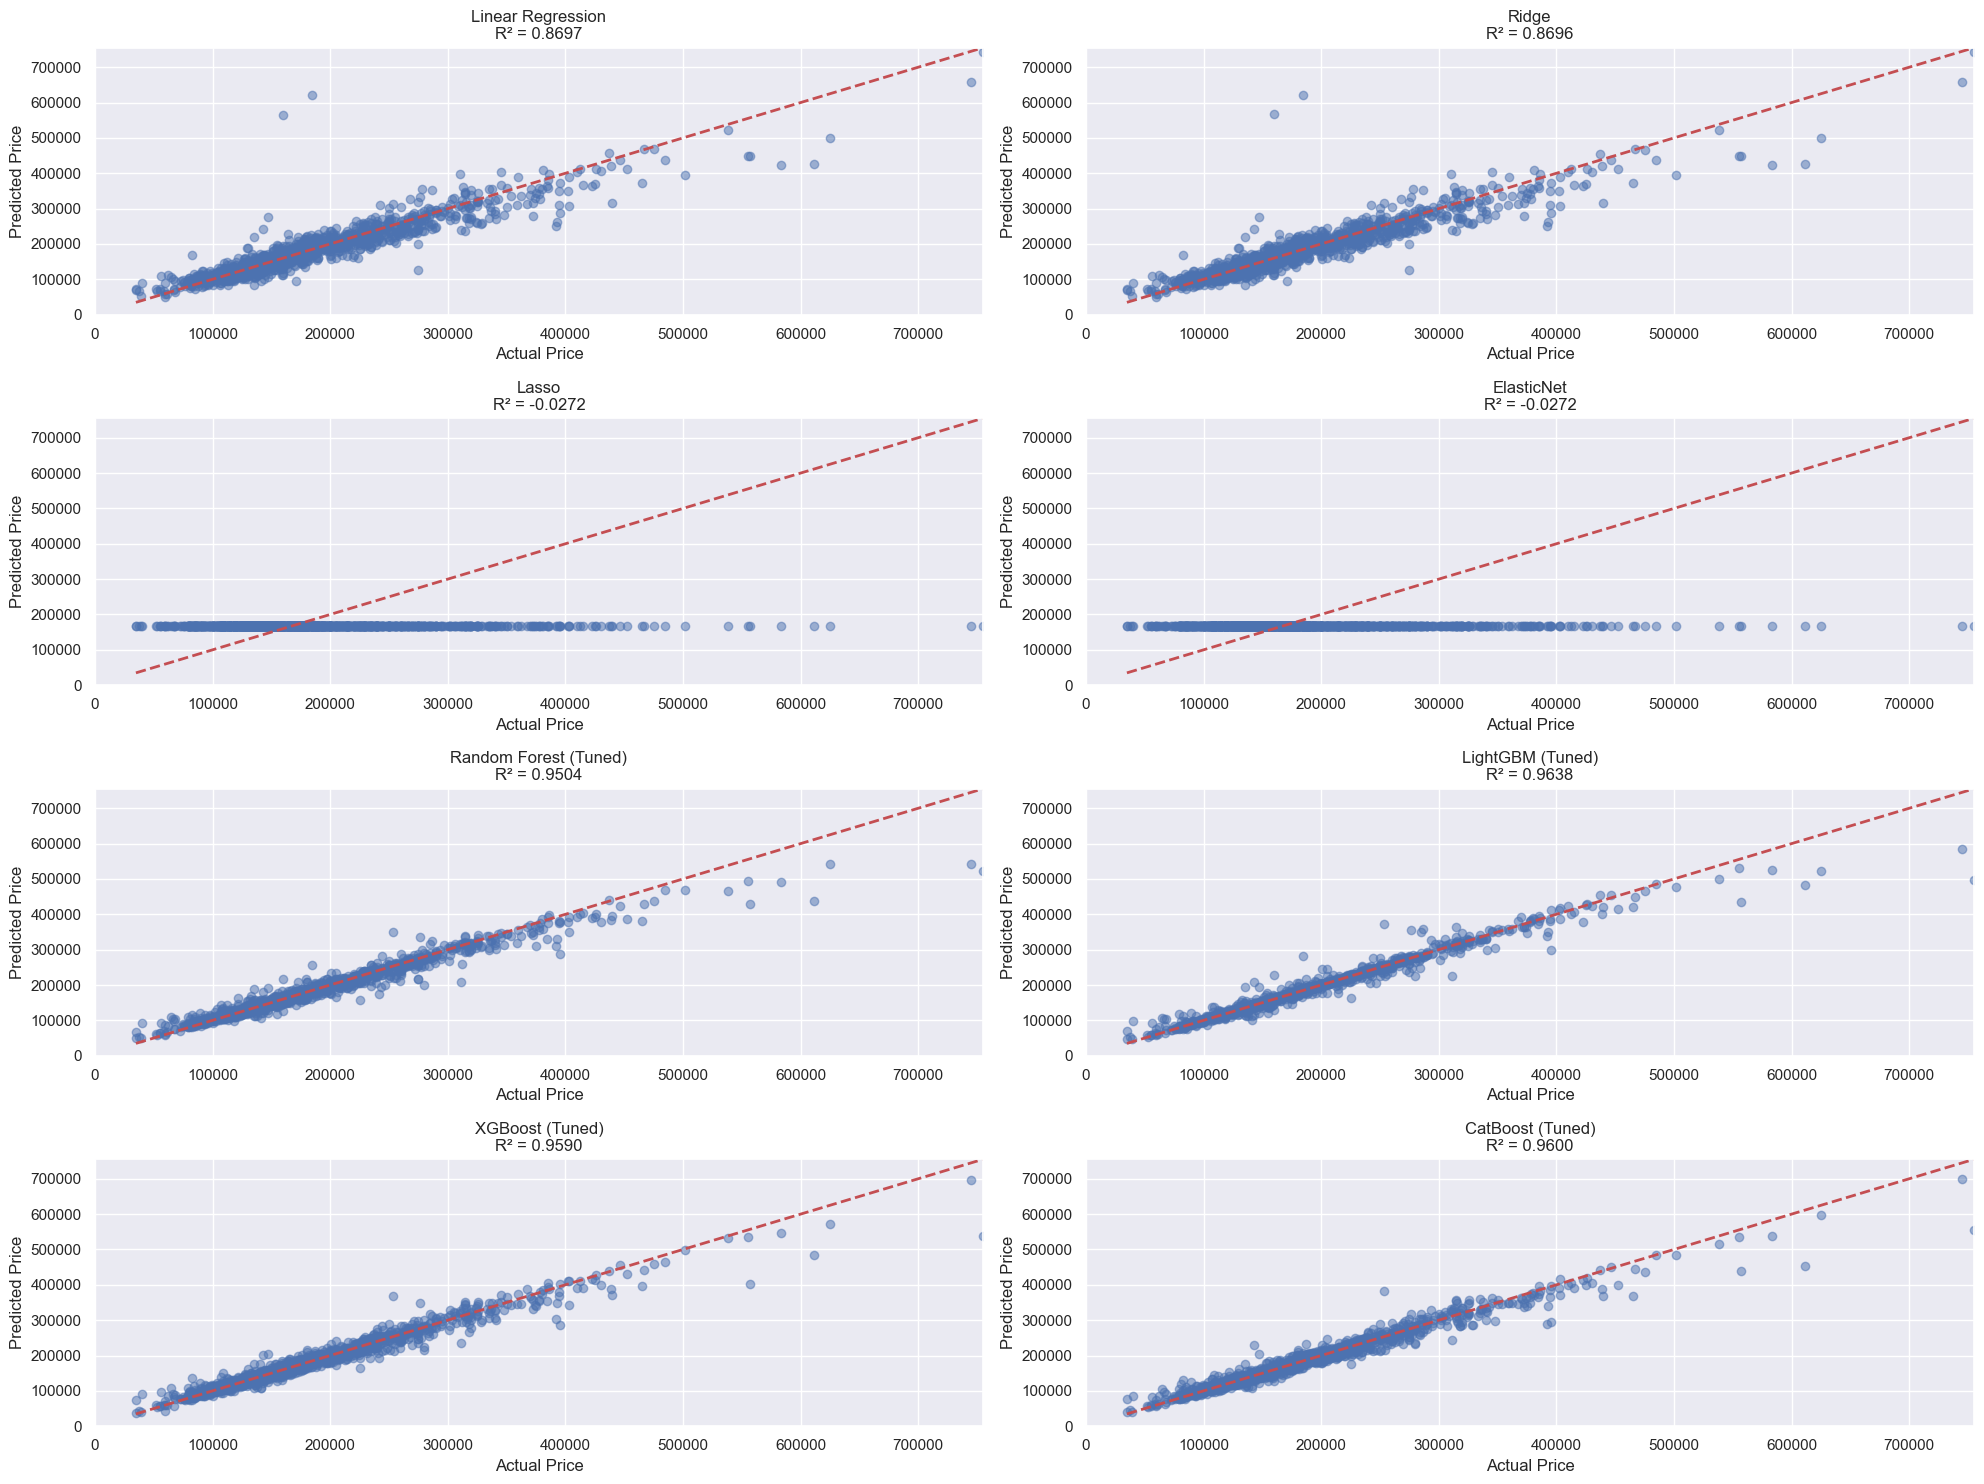

In [15]:
from sklearn.metrics import r2_score

def plot_actual_vs_predicted_all_models(models_results, figsize=(20, 15)):
    n_models = len(models_results)
    rows = (n_models + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=figsize)
    axes = axes.flatten()

    for i, (model_name, results) in enumerate(models_results.items()):
        y_true, y_pred = results
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)

        ax = axes[i]
        ax.scatter(y_true_orig, y_pred_orig, alpha=0.5)
        ax.plot([y_true_orig.min(), y_true_orig.max()],
                [y_true_orig.min(), y_true_orig.max()], "r--", lw=2)
        ax.set_xlabel("Actual Price")
        ax.set_ylabel("Predicted Price")
        ax.set_title(f"{model_name}\nR² = {r2_score(y_true_orig, y_pred_orig):.4f}")
        ax.set_xlim(0, max(y_true_orig.max(), y_pred_orig.max()))
        ax.set_ylim(0, max(y_true_orig.max(), y_pred_orig.max()))

    # Remove extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Prepare results for all models
all_models_results = {
    "Linear Regression": (y, linear_results["Linear Regression"][0].predict(X_scaled)),
    "Ridge": (y, linear_results["Ridge"][0].predict(X_scaled)),
    "Lasso": (y, linear_results["Lasso"][0].predict(X_scaled)),
    "ElasticNet": (y, linear_results["ElasticNet"][0].predict(X_scaled)),
    "Random Forest (Tuned)": (y, rf_final.predict(X)),
}

if lgb_final is not None:
    all_models_results["LightGBM (Tuned)"] = (y, lgb_final.predict(X))

if xgb_final is not None:
    all_models_results["XGBoost (Tuned)"] = (y, xgb_final.predict(X))

if cbt_final is not None:
    all_models_results["CatBoost (Tuned)"] = (y, cbt_final.predict(X))

plot_actual_vs_predicted_all_models(all_models_results)

## Predictions on Test Data

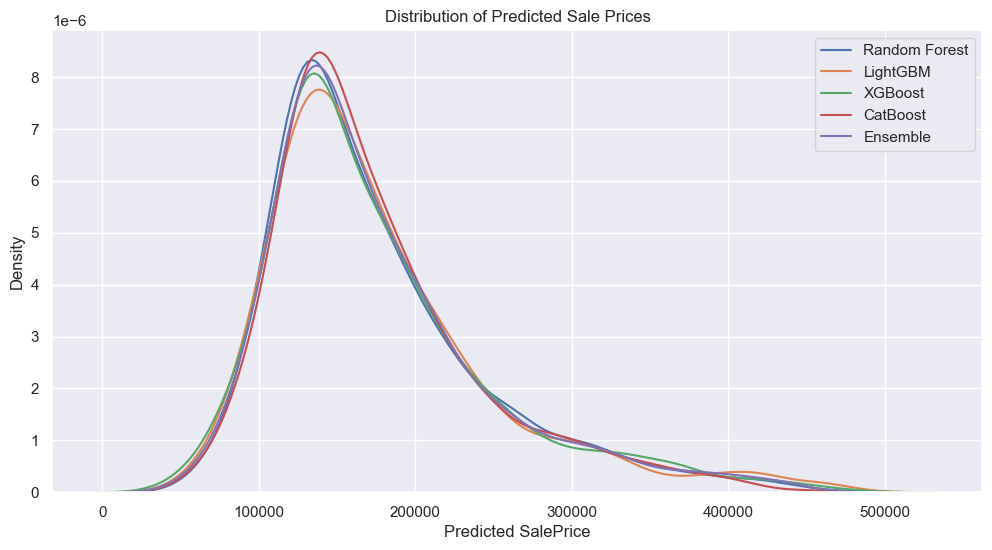

Submission files created.


In [16]:
def make_predictions(model, test_data):
    predictions = model.predict(test_data)
    return np.expm1(predictions)  # invert log transform

# Individual model predictions (guarded)
rf_predictions = make_predictions(rf_final, test_processed)

if lgb_final is not None:
    lgb_predictions = make_predictions(lgb_final, test_processed)
else:
    lgb_predictions = None

if xgb_final is not None:
    xgb_predictions = make_predictions(xgb_final, test_processed)
else:
    xgb_predictions = None

if cbt_final is not None:
    cbt_predictions = make_predictions(cbt_final, test_processed)
else:
    cbt_predictions = None

# Simple ensemble (average of available preds)
pred_list = [p for p in [rf_predictions, lgb_predictions, xgb_predictions, cbt_predictions] if p is not None]
ensemble_predictions = np.mean(np.vstack(pred_list), axis=0) if pred_list else rf_predictions

# KDEs of predicted distributions (if seaborn available)
plt.figure(figsize=(12, 6))
if rf_predictions is not None: sns.kdeplot(rf_predictions, label="Random Forest")
if lgb_predictions is not None: sns.kdeplot(lgb_predictions, label="LightGBM")
if xgb_predictions is not None: sns.kdeplot(xgb_predictions, label="XGBoost")
if cbt_predictions is not None: sns.kdeplot(cbt_predictions, label="CatBoost")
sns.kdeplot(ensemble_predictions, label="Ensemble")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Predicted Sale Prices")
plt.legend()
plt.show()

# Write submissions
pd.DataFrame({"Id": test["Id"], "SalePrice": ensemble_predictions}).to_csv("submission_ensemble.csv", index=False)
pd.DataFrame({"Id": test["Id"], "SalePrice": rf_predictions}).to_csv("submission_rf.csv", index=False)
if lgb_predictions is not None: pd.DataFrame({"Id": test["Id"], "SalePrice": lgb_predictions}).to_csv("submission_lgb.csv", index=False)
if xgb_predictions is not None: pd.DataFrame({"Id": test["Id"], "SalePrice": xgb_predictions}).to_csv("submission_xgb.csv", index=False)
if cbt_predictions is not None: pd.DataFrame({"Id": test["Id"], "SalePrice": cbt_predictions}).to_csv("submission_cbt.csv", index=False)

print("Submission files created.")

## Model Comparison and Best Model Selection

Model Performance Comparison:
                   Model          RMSE           MAE        R2
5       LightGBM (Tuned)  15110.314189   6191.016792  0.963797
7       CatBoost (Tuned)  15878.735704   9573.044451  0.960022
6        XGBoost (Tuned)  16082.677926   9731.326948  0.958988
4  Random Forest (Tuned)  17689.051733   9273.214268  0.950386
0      Linear Regression  28669.968662  16545.570124  0.869669
1                  Ridge  28677.453861  16544.187325  0.869601
3             ElasticNet  80488.555134  55668.344525 -0.027212
2                  Lasso  80488.555134  55668.344525 -0.027212

Best Performing Model:
Model: LightGBM (Tuned)
RMSE: 15110.3142
MAE: 6191.0168
R2 Score: 0.9638


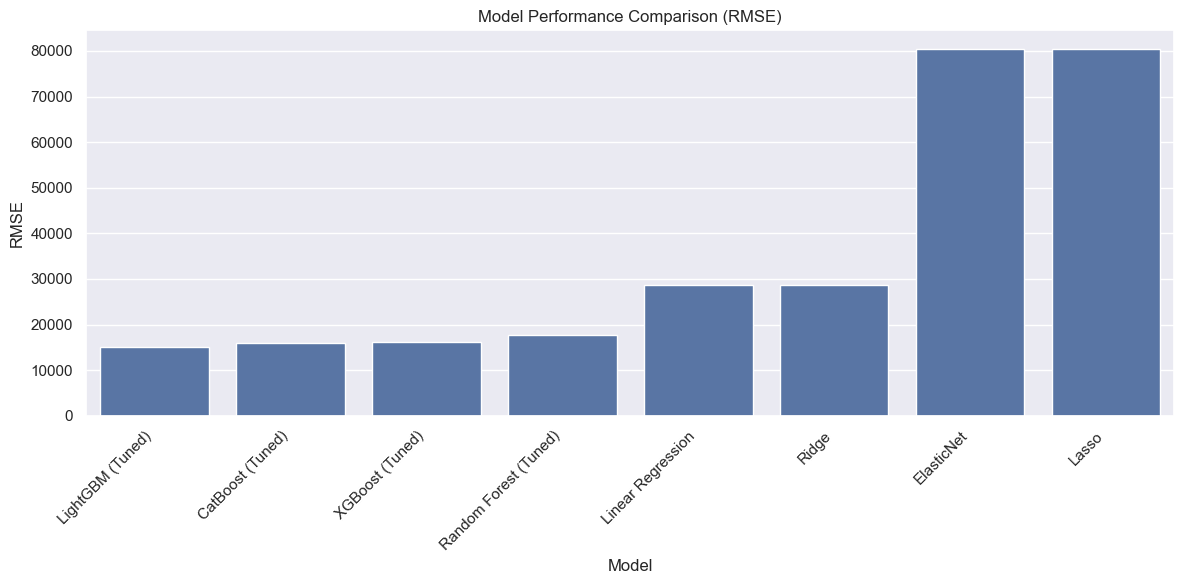

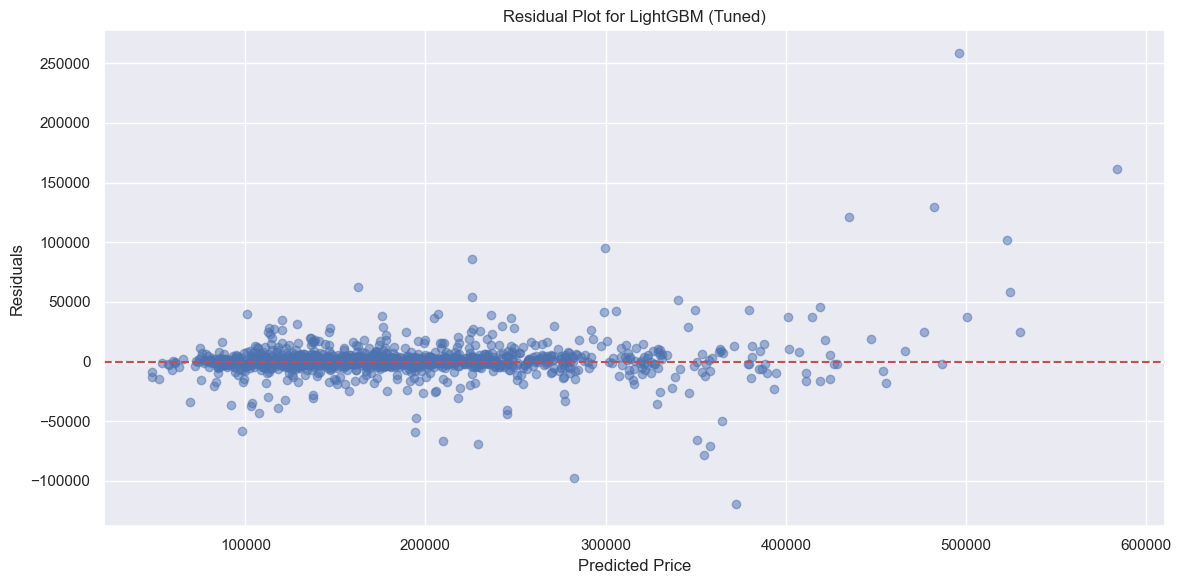

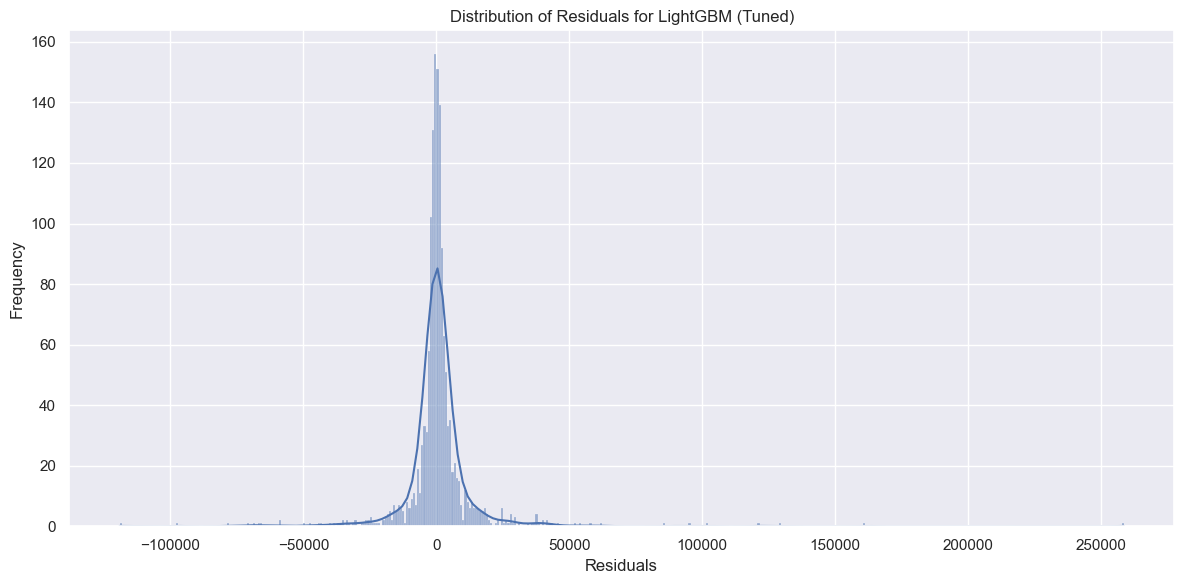

In [17]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "R2": r2}

model_results = []
for model_name, (y_true, y_pred) in all_models_results.items():
    model_results.append(evaluate_model(np.expm1(y_true), np.expm1(y_pred), model_name))

results_df = pd.DataFrame(model_results).sort_values("RMSE")
print("Model Performance Comparison:")
print(results_df)

best_model_row = results_df.iloc[0]
best_model_name = best_model_row["Model"]
print("\nBest Performing Model:")
print(f"Model: {best_model_name}")
print(f"RMSE: {best_model_row['RMSE']:.4f}")
print(f"MAE: {best_model_row['MAE']:.4f}")
print(f"R2 Score: {best_model_row['R2']:.4f}")

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="RMSE", data=results_df)
plt.title("Model Performance Comparison (RMSE)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Residual analysis for the selected best model
y_true = np.expm1(y)
y_pred = np.expm1(all_models_results[best_model_name][1])
residuals = y_true - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title(f"Residual Plot for {best_model_name}")
plt.axhline(y=0, color="r", linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title(f"Distribution of Residuals for {best_model_name}")
plt.tight_layout()
plt.show()


## Conclusion

**Summary of the pipeline:**
1. Performed EDA to understand distributions, correlations, and key drivers of `SalePrice`.
2. Preprocessed data with median/mode imputation and label encoding for categorical fields.
3. Modeled with linear baselines and tree-based models (RandomForest, and optionally LightGBM/XGBoost/CatBoost).
4. Visualized performance and feature importance; tuned selected models with `GridSearchCV`.
5. Finalized and compared models; generated single-model and ensemble predictions for submission.
6. Used **log-transform** of the target to handle right-skew and reduce the influence of outliers.
